In [4]:
#!pip install opencv-python

In [1]:
import os, glob, cv2, shutil, joblib,gc, random, re
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import random
import warnings
warnings.filterwarnings(action='ignore')
import datetime
print(datetime.datetime.today())

2022-11-07 10:49:01.313126


In [2]:
def video_gray2rgb(df):
    out=np.zeros(df.shape[:3]+(3,),dtype='u1')
    for i in range(df.shape[0]):
        img=cv2.cvtColor(df[i,:,:,0],cv2.COLOR_GRAY2RGB)
        out[i,:,:,:]=img   
        del img
    return out
def batch_avi(data,idx,BATCH_SIZE=1024,font=cv2.FONT_HERSHEY_SIMPLEX):
    def label_vis(data,i,font):
        input_img=cv2.cvtColor(data[i,:,:,0],cv2.COLOR_GRAY2RGB
                            ).astype('u1')
        
        pred_img=cv2.cvtColor(data[i,:,:,1]*255,cv2.COLOR_GRAY2RGB
                            ).astype('u1')
        pred_img[:,:,(0,2)]=0
        
        label_img=cv2.addWeighted(input_img,1,pred_img,.2,0)
        text=f"Index : {i}"
        cv2.putText(label_img,text, (80,30),font,1,(255,0,0),2)
        
        return np.expand_dims(label_img,axis=0)
    return np.concatenate([label_vis(data,i, font) 
                    for i in range((BATCH_SIZE*idx),
                                   (np.min([data.shape[0],(idx+1)*BATCH_SIZE])))])

def write_avi(data,file_name,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    (width, height)=data.shape[1:3]
    out = cv2.VideoWriter(file_name, fourcc, fps, (height, width),isColor=True)
    for i in range(len(data)):
        out.write(data[i])
    out.release()
    
def my_confusion_matrix(y_true,y_pred,cutoff=.5):
    label_true=y_true>=.5
    pred_true=y_pred>=cutoff
    label_false= ~ label_true
    pred_false = ~ pred_true
    tp=np.sum(label_true&pred_true)
    fn=np.sum(label_true)-tp
    fp=np.sum(label_false&pred_true)
    tn=np.sum(label_false)-fp
    return tp,fn,fp,tn

# 모델링

In [3]:
def get_feature(file):
    df=pd.read_csv(file,sep='\t')
    df['diagnosis_group']=file.split('/')[-1].split('.')[0]
    ls=list()
    for i in df.converted.values:
        ls.append(glob.glob(
            f"/root/lustre/data/vHIT/s3/final/final_20221101_count/1.Dataset/**/{i}/")[0])
    df['input_path']=ls
    output=df[['converted','age','sex','input_path','diagnosis_group']]
    output.loc[:,['LA','LP','Left','RA','RP','Right']]=0
    for i,(path,patent) in tqdm(enumerate(df[['input_path','converted']].values)):
        try:
            file=glob.glob(f"{path}/*.tsv")[0]
            file="/root"+os.path.realpath(file)
            output.loc[i,'path']=file
            feature_df=pd.read_csv(file,sep='\t')
            feature=feature_df[['Direction','Gain']].groupby(['Direction']).mean().T
            output.loc[i,feature.columns]=feature.values[0,:]
        except:
            output.loc[i,'path']=''
    output=output[['age','sex','diagnosis_group','LA','LP','Left','RA','RP','Right','path']]

    return output

In [4]:
files=glob.glob("/root/lustre/data/vHIT/s3/final/final_20221101_count/1.Dataset/*.tsv")
#model_files=np.array(sorted([i for i in files if re.compile('raw').findall(i)]))
len(files)

3

In [5]:
model_files=[get_feature(file) for file in files]
model_files=pd.concat(model_files)
model_files.loc[model_files.sex=='F ','sex']='F'
model_files.loc[model_files.sex=='F ','sex']='F'
model_files.loc[model_files.sex=='f','sex']='F'
model_files.loc[model_files.sex=='m','sex']='M'
model_files[["F","M"]]=pd.get_dummies(model_files['sex'])
model_files=model_files.drop('sex',axis=1)
model_files=model_files.dropna()
model_files=model_files[model_files.path!=''].reset_index().drop('index',axis=1)

2550it [01:14, 34.33it/s]
6617it [03:08, 35.11it/s]
5402it [02:26, 36.94it/s]


In [6]:
print(model_files.diagnosis_group.value_counts())
print(model_files.diagnosis_group.value_counts()/model_files.diagnosis_group.value_counts().sum())

Peripheral type    6502
Normal             5247
Central type       2513
Name: diagnosis_group, dtype: int64
Peripheral type    0.455897
Normal             0.367901
Central type       0.176202
Name: diagnosis_group, dtype: float64


## 모델링 수행

In [ ]:
#!pip install lightgbm
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
from sklearn.metrics import accuracy_score
import sklearn
from sklearn.ensemble import RandomForestClassifier
kf = KFold(n_splits = 3, shuffle = True)
target_label=np.array(['Peripheral type','Normal','Central type'])
params={"num_leaves":[20,40,60,80,100],
        "min_child_samples":[5,10,15],
        "max_depth":[-1,5,10,2],
        "learning_rate":[0.05,0.1,0.2],
        "reg_alpha":[0,0.01,0.03],
       }

tp_sum=dict();fn_sum=dict();fp_sum=dict();tn_sum=dict()
for K, (train_idx,test_idx) in enumerate(kf.split(model_files),1):    
    for cutoff in np.arange(0,1.1,0.05):
        for target in target_label:
            cond=f"K_{K}_target_{target}_cutoff_{cutoff:.2f}"
            tp_sum[cond]=0;fn_sum[cond]=0;fp_sum[cond]=0;tn_sum[cond]=0
    
    train_files=model_files.loc[train_idx,:]
    test_files=model_files.loc[test_idx,:]
    tr_x=train_files.drop(['path','diagnosis_group'],axis=1)
    tr_y=train_files.diagnosis_group
    
    train_files, valid_files=train_test_split(
        train_files, test_size=.2, random_state=42)
    train_files=train_files.sort_index()
    valid_files=valid_files.sort_index()
    test_files=test_files.sort_index()
    tr_x_=train_files.drop(['path','diagnosis_group'],axis=1)
    tr_y_=train_files.diagnosis_group
    val_x_=valid_files.drop(['path','diagnosis_group'],axis=1)
    val_y_=valid_files.diagnosis_group
    te_x=test_files.drop(['path','diagnosis_group'],axis=1)
    te_y=test_files.diagnosis_group
    
    print(train_files.diagnosis_group.value_counts())
    print(test_files.diagnosis_group.value_counts())
    ###################
    """
    모델 생성
    """
    class_weight={
        "Peripheral type":.15,
        "Normal":.25,
        "Central type":.6}
    
    # rf=RandomForestClassifier(
    #     random_state=42,n_estimators=500,
    #     class_weight={"Peripheral type":.1,"Normal":.35,"Central type":.55})
    # rf.fit(X=tr_x,y=tr_y)
    # joblib.dump(rf,f'rf_{K}_fold.pkl')
    # y_trues=np.concatenate([(i==target_label).astype('int')[np.newaxis] for i in te_y])
    # y_preds=rf.predict_proba(te_x)
    
    lgbm=lgb.LGBMClassifier(
        metric="multi_logloss",num_class=3,objective="multiclass",
        n_estimators=400,random_state=10042,class_weight=class_weight)
    clf=GridSearchCV(lgbm,params,scoring="accuracy",verbose=1,n_jobs=-1,cv=3)
    clf.fit(X=tr_x,y=tr_y)
    lgbm.set_params(**clf.best_params_)
    lgbm.fit(tr_x_, tr_y_, early_stopping_rounds=300,verbose=0,eval_set=[(val_x_,val_y_)])
    joblib.dump(lgbm,f'lgbm_{K}_fold.pkl')
    y_trues=np.concatenate([(i==target_label).astype('int')[np.newaxis] for i in te_y])
    y_preds=lgbm.predict_proba(te_x)
    ###################
    """
    모델 검증
    """
    for target in range(3):
        y_true=y_trues[:,target]
        y_pred=y_preds[:,target]
        for cutoff in np.arange(0,1.1,0.05):
            cond=f"K_{K}_target_{target_label[target]}_cutoff_{cutoff:.2f}"
            tp,fn,fp,tn=my_confusion_matrix(y_true,y_pred,cutoff)
            tp_sum[cond]+=tp;fn_sum[cond]+=fn;fp_sum[cond]+=fp;tn_sum[cond]+=tn

Peripheral type    3480
Normal             2808
Central type       1318
Name: diagnosis_group, dtype: int64
Peripheral type    2158
Normal             1752
Central type        844
Name: diagnosis_group, dtype: int64
Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Peripheral type    3459
Normal             2819
Central type       1328
Name: diagnosis_group, dtype: int64
Peripheral type    2184
Normal             1739
Central type        831
Name: diagnosis_group, dtype: int64
Fitting 3 folds for each of 540 candidates, totalling 1620 fits


In [66]:
# joblib.dump([tp_sum,fn_sum,fp_sum,tn_sum],'진단모델지표.pkl')
from itertools import cycle
import matplotlib.pyplot as plt 
import numpy as np
import joblib
from sklearn import metrics
# tp_sum,fn_sum,fp_sum,tn_sum=joblib.load('진단모델지표.pkl')

In [28]:
target_label

array(['Peripheral type', 'Normal', 'Central type'], dtype='<U15')

In [68]:
target="Central type"
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
roc_aucs=dict()
for target in target_label:
    tpr=dict();fpr=dict()
    for K in range(1,4):
        tpr[K]=list();fpr[K]=list()    
        for i in np.arange(0,1.1,.05):
            tpr[K].append(tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
                tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+fn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
            fpr[K].append(fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
                fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+tn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
        tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])

    for K,color in zip(range(1,4),colors):
        roc_auc=metrics.auc(fpr[K],tpr[K])
        roc_aucs[f"{target}_{K}"]=roc_auc

In [69]:
roc_aucs

{'Peripheral type_1': 0.48138729238972744,
 'Peripheral type_2': 0.4612695180449505,
 'Peripheral type_3': 0.453188267830105,
 'Normal_1': 0.641934505772581,
 'Normal_2': 0.6498887803120639,
 'Normal_3': 0.6513079940617974,
 'Central type_1': 0.44776458163492183,
 'Central type_2': 0.4562354003941894,
 'Central type_3': 0.4535107206037381}

In [70]:
np.mean(list(roc_aucs.values()))

0.5218318956715637

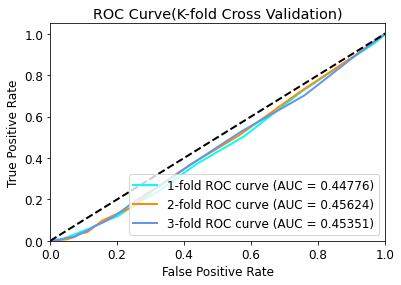

In [71]:
target="Central type"
tpr=dict();fpr=dict();roc_aucs=dict()
for K in range(1,4):
    tpr[K]=list();fpr[K]=list()    
    for i in np.arange(0,1.1,.05):
        tpr[K].append(tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
            tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+fn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
        fpr[K].append(fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
            fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+tn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
    tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])
    
plt.figure()
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams.update({'font.size': 12})
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
lw=2
for K,color in zip(range(1,4),colors):
    roc_auc=metrics.auc(fpr[K],tpr[K])
    roc_aucs[K]=roc_auc
    plt.plot(
        fpr[K],
        tpr[K],
        label=f"{K}-fold ROC curve (AUC = {roc_auc:0.5f})",
        color=color,
        lw=lw
    )
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(K-fold Cross Validation)")
plt.legend(loc="lower right")
plt.show()